In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import wasserstein_distance

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.titlesize"] = 30

NUM_TOPICS = 30


cmap = matplotlib.cm.get_cmap('CMRmap')
my_color = [cmap(x/30) for x in range(0,30)]

/Users/scott/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
topic_dict = {
    16: ['case','report','coronavirus','country'],
    23: ['Italy','coronavirus','govern','country','europe'],
    11: ['china','wuhan','outbreak','virus','case'],
    2:  ['march','reuter','coronavirus','edit','report'],
    8:  ['bank','economy','said','rate','market'],
    17: ['market','stock','index','investor','dollar'],
    30: ['like','go','now','time','people','even'],
    12: ['virus','health','people','coronavirus','case','disease'],
    28: ['$','economy','year','billion','million','impact'],
    19: ['trump','presid','said','coronavirus','test'],
    7:  ['people','get','can','go','home'],
    13: ['state','new','said','york','city','case'],
    10: ['billion','business','fund','help','worker'],
    14: ['employee','said','work','office','home'],
    4:  ['flight','airline','travel','passenger','ship','cruise'],
    22: ['event','cancel','postpone','game','march'],
    29: ['china','product','factory','supply','manufacture'],
    27: ['hospital','mask','medic','care','patient','said'],
    15: ['oil','price','demand','said'],
    20: ['test','vaccine','drug','coronavirus','treatment'],
    5:  ['company','google','business','data','tech','app'],
    26: ['store','food','worker','delivery','amazon','restaurant'],
    18: ['senate','democrat','vote','house','republican','bill','trump'],
    9:  ['govern','prison','court','state'],
    21: ['coronavirus','media','post','news','twitter'],
    25: ['show','new','movie','theater','disney'],
    1:  ['coronavirus','hill','capitol','dc','washionton'],
    3:  ['window','taboola','cpronavirus','inside','us'],
    24: ['school','student','university','close','class','college'],
    6:  ['de','la','el','que','en','y']
}

In [3]:
data = pd.read_csv('combined-v2-drop-na.csv',index_col=0,parse_dates=['date'])
gamma = pd.read_csv('topic_td_gamma_topics_v2.csv',index_col=0)
for i in range(1,NUM_TOPICS+1):
    data[str(i)]=gamma[gamma.topic==i].gamma.values
data.head()


/Users/scott/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,title,date,article,publication,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,30
1,COVID-19_pandemic,2020-01-05,"2019-2020 China pneumonia outbreak, or China p...",Wikipedia,9.180428e-07,0.000002,0.000004,5.721877e-06,0.000034,5.246082e-06,...,0.000004,0.000020,2.794534e-09,0.101686,1.995021e-06,0.000002,9.242181e-06,0.000002,0.000017,7.971495e-07
2,COVID-19_pandemic,2020-01-05,"2019-2020 China pneumonia outbreak, or China p...",Wikipedia,9.180428e-07,0.000002,0.000004,5.721877e-06,0.000034,5.246082e-06,...,0.000004,0.000020,2.794534e-09,0.101686,1.995021e-06,0.000002,9.242181e-06,0.000002,0.000017,7.971495e-07
3,COVID-19_pandemic,2020-01-06,"2019-2020 China pneumonia outbreak, or China p...",Wikipedia,1.272445e-06,0.000001,0.000006,2.637815e-07,0.000012,2.865545e-08,...,0.000004,0.000006,9.841268e-09,0.000077,4.814592e-07,0.000002,1.979329e-08,0.000004,0.000020,1.990460e-06
4,COVID-19_pandemic,2020-01-06,"2019-2020 China pneumonia outbreak, or China p...",Wikipedia,1.476476e-06,0.000002,0.000007,3.662248e-06,0.000031,1.803208e-06,...,0.000005,0.000015,9.970100e-09,0.024937,1.726134e-06,0.000002,2.297403e-06,0.000004,0.000020,1.466330e-06
5,COVID-19_pandemic,2020-01-06,"2019-2020 China pneumonia outbreak, or China p...",Wikipedia,2.569474e-06,0.000009,0.000009,1.361251e-05,0.000165,7.938351e-06,...,0.000017,0.000045,1.724181e-08,0.210031,4.187353e-06,0.000005,1.287838e-05,0.000015,0.000068,1.931407e-06


In [26]:
def perc_specific_topic(data, my_color,topic_number=None):
    # get date ready
    selected_topic = data[['date']+[str(i) for i in range(1,NUM_TOPICS+1)]]#.set_index(keys='date',drop=True)
    selected_topic = selected_topic[selected_topic['date'] <= '2020-4-1']
    selected_topic['date']=selected_topic.date.dt.date

    # get rolling percentage
    selected_topic = selected_topic.groupby('date').sum()
    selected_topic.index = [pd.Timestamp(x) for x in selected_topic.index]
    selected_topic_rolling = selected_topic.rolling('3D').mean()
    selected_topic_perc = selected_topic_rolling.divide(selected_topic_rolling.sum(axis=1), axis=0).fillna(0)

    idx = pd.date_range('2020-01-01', periods=92, freq='D')
    df_temp = (pd.DataFrame(selected_topic_perc, index=idx).fillna(0) + selected_topic_perc).fillna(0)


    return df_temp

def plot_specific_topic(data, my_color,topic_number=None):
    # get date ready
    selected_topic = data[['date']+[str(i) for i in range(1,NUM_TOPICS+1)]]#.set_index(keys='date',drop=True)
    selected_topic = selected_topic[selected_topic['date'] <= '2020-4-1']

    # get rolling percentage
    selected_topic = selected_topic.groupby('date').sum()
    selected_topic_rolling = selected_topic.rolling('3D').mean()
    selected_topic_perc = selected_topic_rolling.divide(selected_topic_rolling.sum(axis=1), axis=0).fillna(0)

    #plot
    if topic_number:
        
        selected_topic_perc.plot.area(ylim=(0,1),figsize=(20,10),
                                  color=[my_color[x]  if x==topic_number-1  else (my_color[x][0],my_color[x][1],my_color[x][2],0.5) for x in range(30)],
                                  #title='Percentage of Topic %d(%s) changes per day'%(topic_number,topic_dict[topic_number]),
                                  )
    else:
        selected_topic_perc.plot.area(ylim=(0,1),figsize=(20,10),color=my_color)
    plt.show()

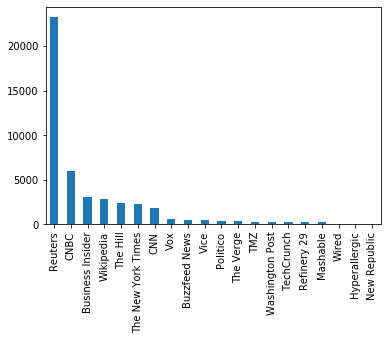

In [5]:
data.publication.value_counts().plot(kind='bar')

In [6]:
data.publication.value_counts()

Reuters               23242
CNBC                   6012
Business Insider       3109
Wikipedia              2870
The Hill               2407
The New York Times     2293
CNN                    1858
Vox                     556
Buzzfeed News           487
Vice                    455
Politico                389
The Verge               358
TMZ                     327
Washington Post         324
TechCrunch              310
Refinery 29             262
Mashable                244
Wired                   103
Hyperallergic            26
New Republic             22
Name: publication, dtype: int64

In [7]:
data_resample = data.groupby('publication').apply(lambda x:x.sample(n=10000,replace=True))

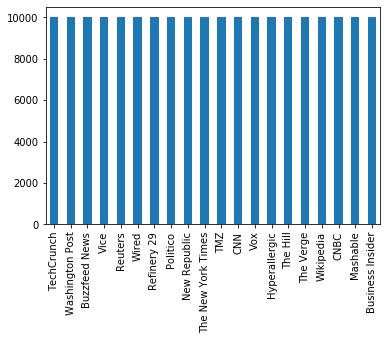

In [8]:
data_resample.publication.value_counts().plot(kind='bar')

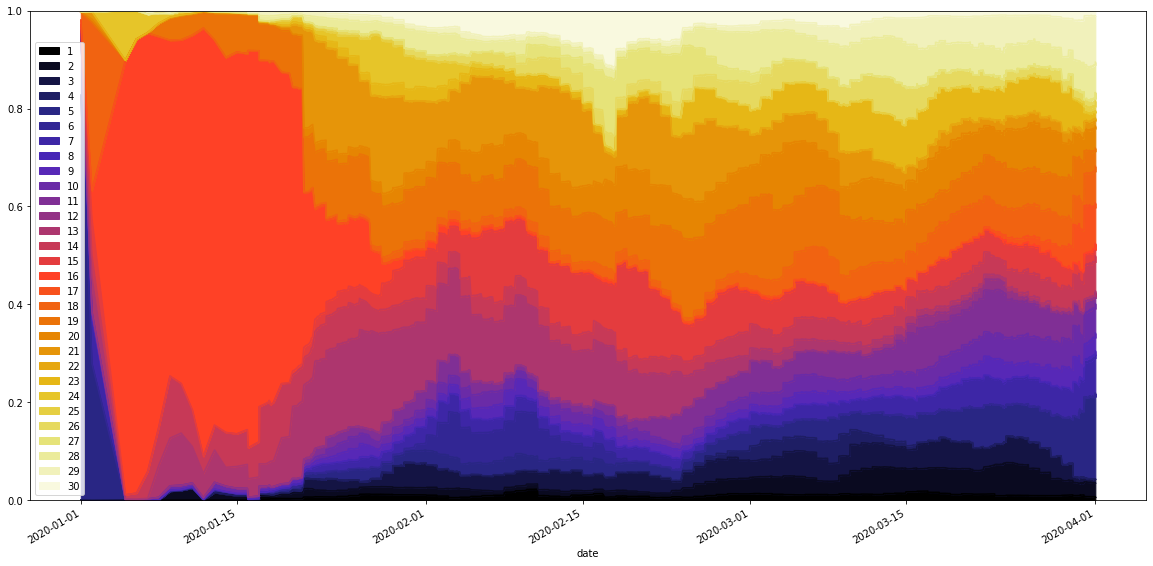

In [9]:
plot_specific_topic(data, my_color,topic_number=None)

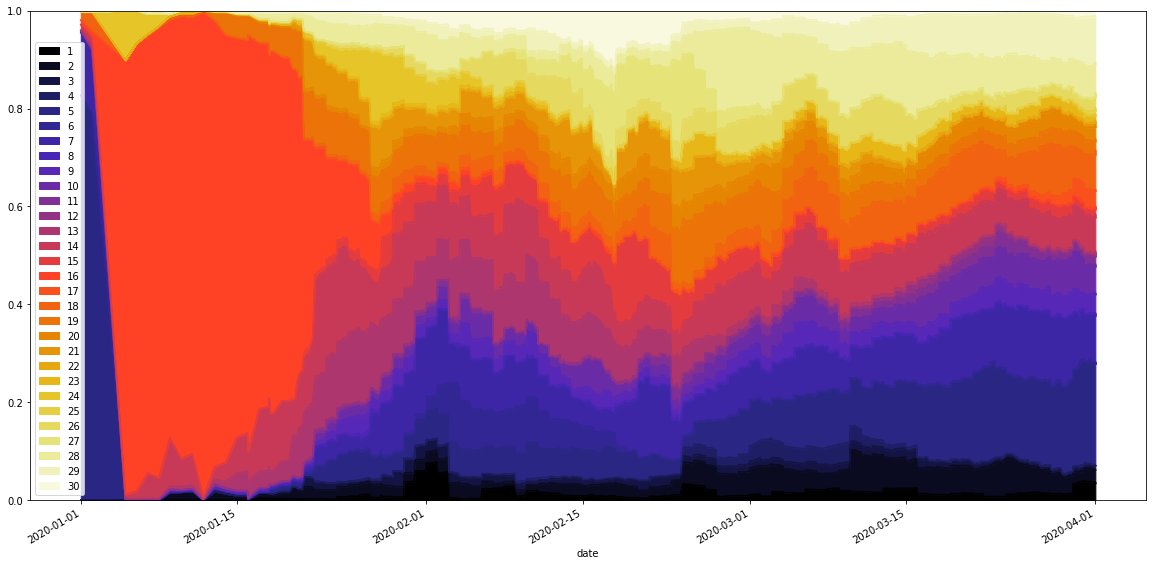

In [10]:
data_resample = data.groupby('publication').apply(lambda x:x.sample(n=6030,replace=True))
plot_specific_topic(data_resample, my_color,topic_number=None)

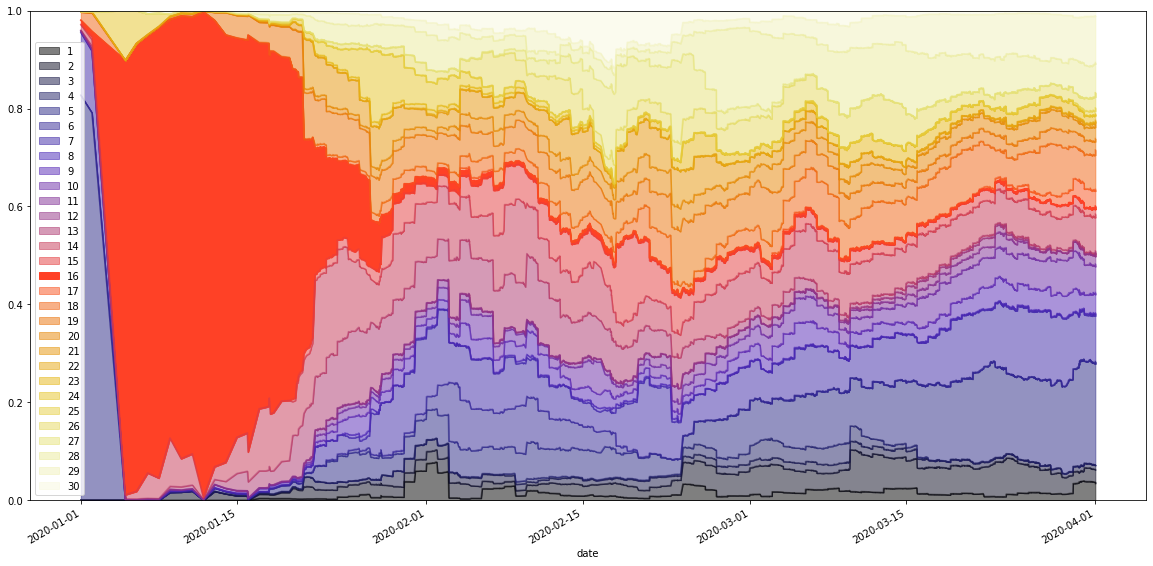

In [27]:
plot_specific_topic(data_resample, my_color,topic_number=16)

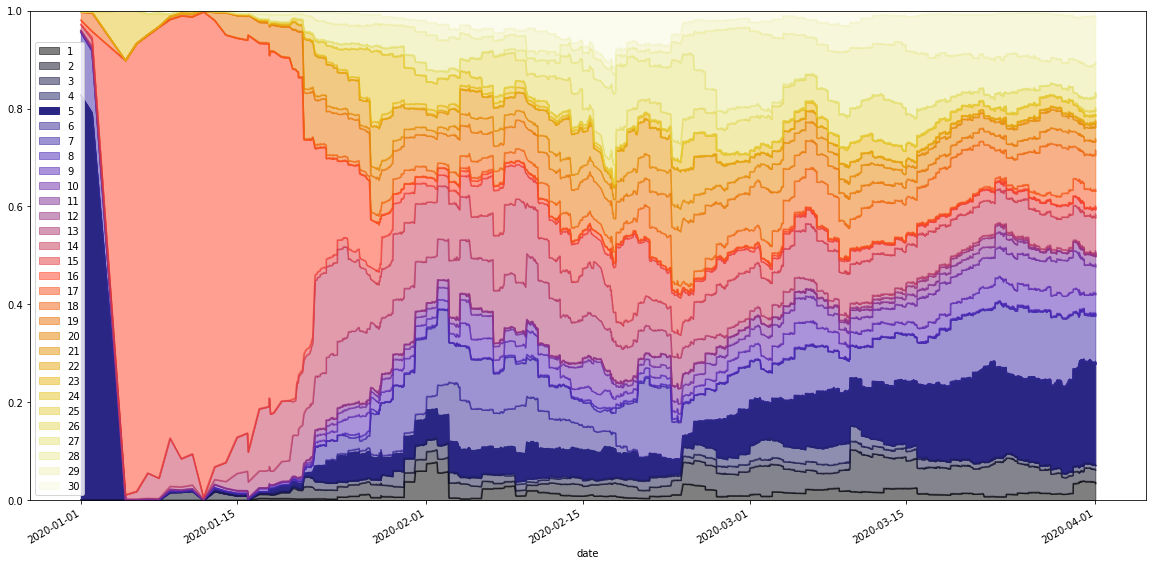

In [36]:
plot_specific_topic(data_resample, my_color,topic_number=5)

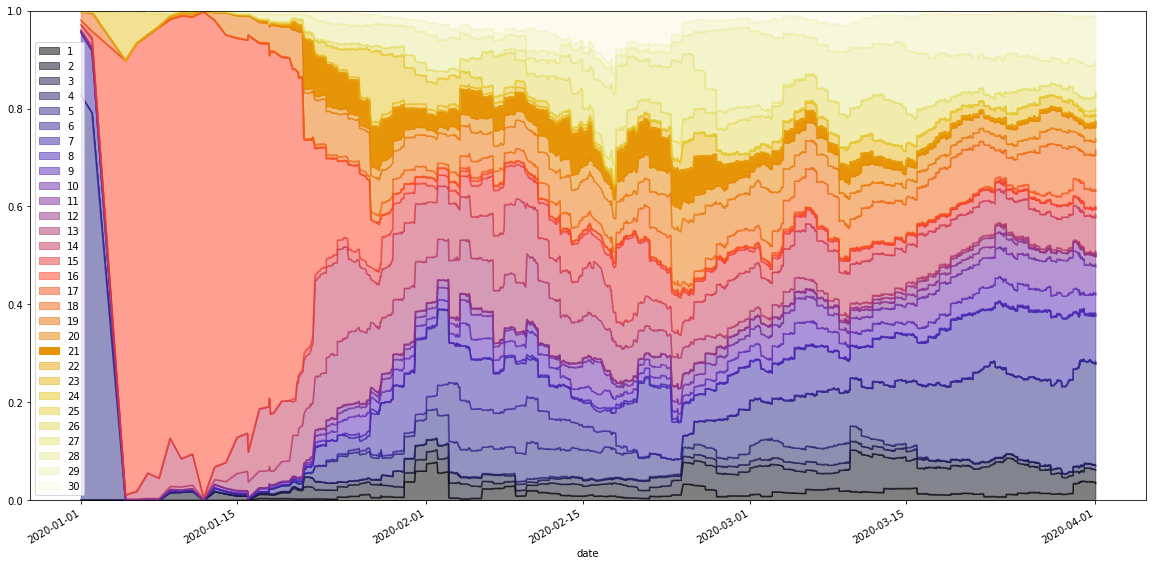

In [37]:
plot_specific_topic(data_resample, my_color,topic_number=21)

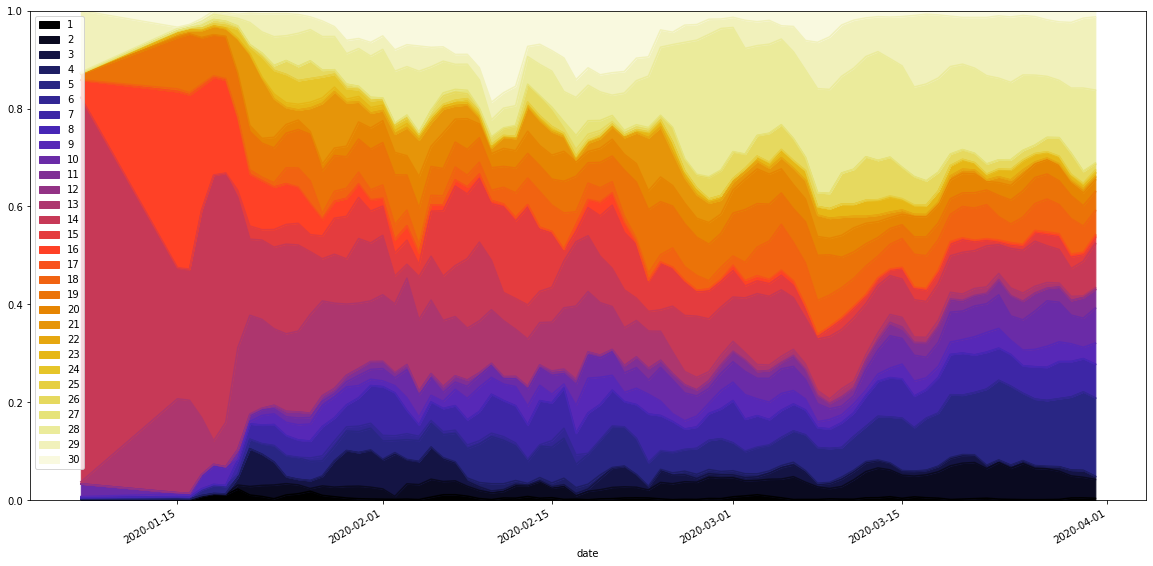

In [21]:
plot_specific_topic(data_resample[data_resample.publication=='CNN'], my_color,topic_number=None)

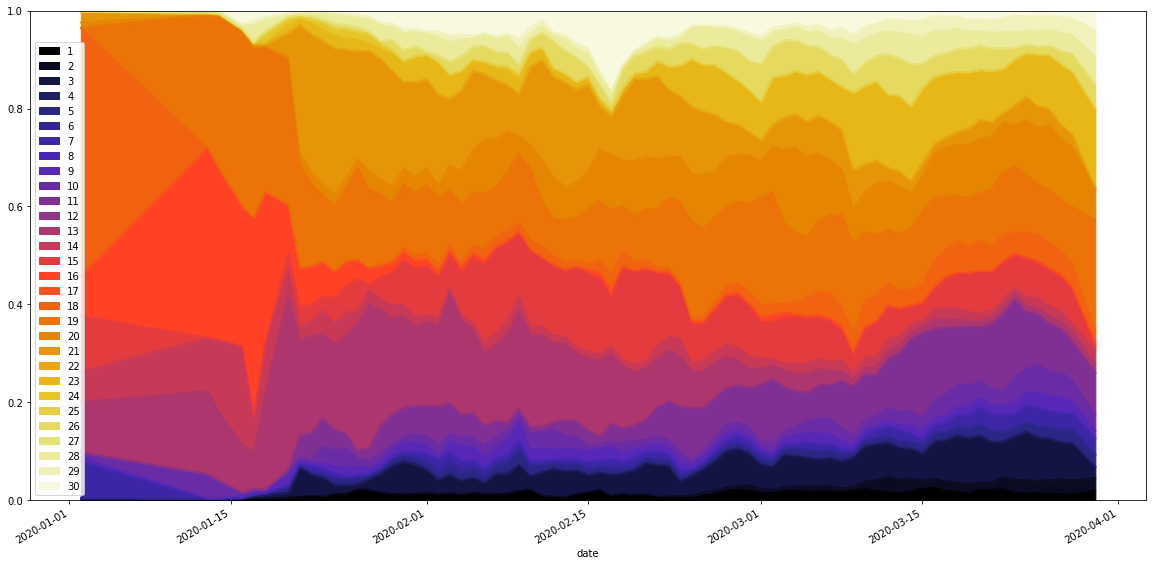

In [22]:
plot_specific_topic(data_resample[data_resample.publication=='Reuters'], my_color,topic_number=None)

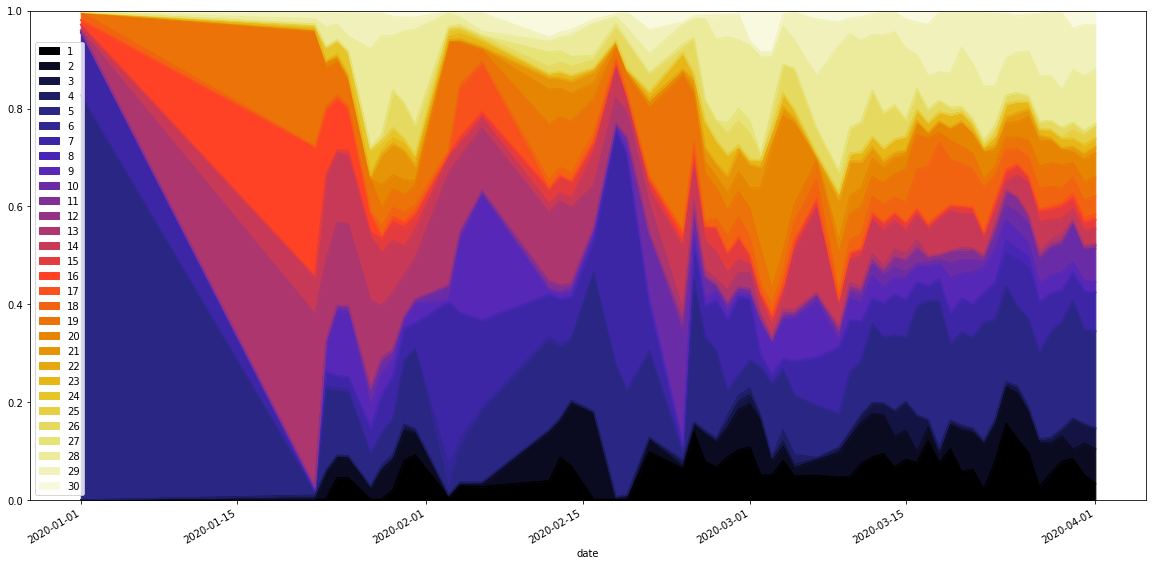

In [23]:
plot_specific_topic(data_resample[data_resample.publication=='Washington Post'], my_color,topic_number=None)

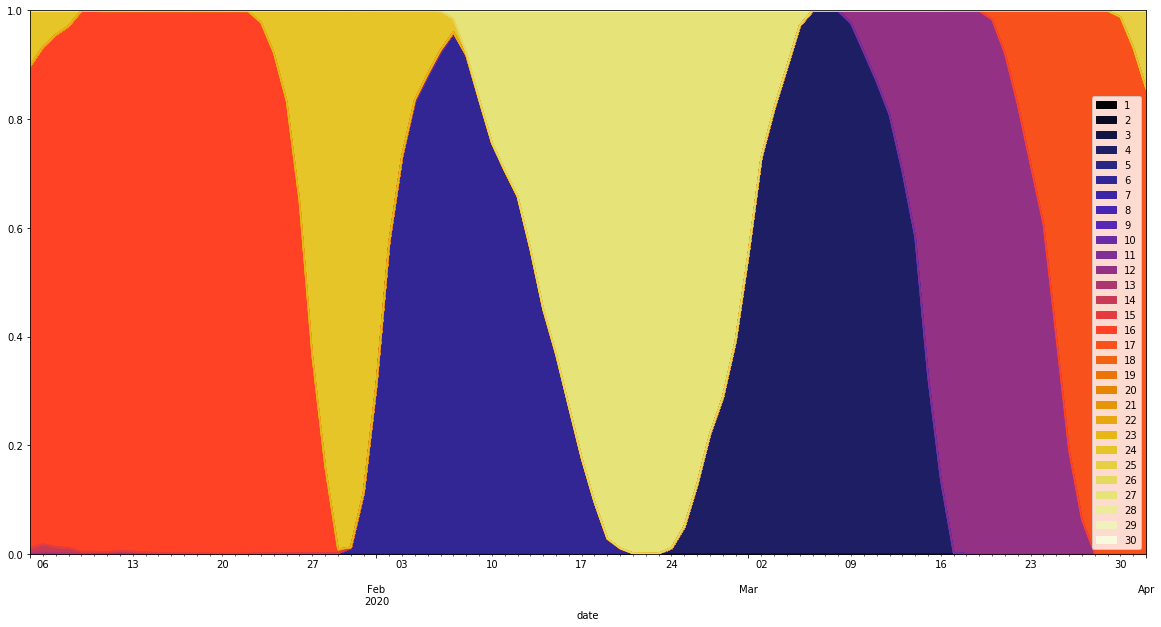

In [20]:
plot_specific_topic(data_resample[data_resample.publication=='Wikipedia'], my_color,topic_number=None)

In [11]:
total_distribution = perc_specific_topic(data_resample, my_color,topic_number=None)
dist_dict = {}
for source in set(data_resample.publication):
    dist_dict[source] = perc_specific_topic(data_resample[data_resample.publication==source], my_color,topic_number=None)

In [12]:
wasserstein_distance(total_distribution.T.values.flatten(),dist_dict['CNN'].T.values.flatten())

0.011783186793867442

In [15]:
wscore_dict = {}
lscore_dict = {}
for source, table in dist_dict.items():
    mat = total_distribution.values - table.values
    lscore = np.linalg.norm(mat)
    wscore = wasserstein_distance(total_distribution.T.values.flatten(),table.T.values.flatten())
    wscore_dict[source]=wscore
    lscore_dict[source]=lscore


    print("the Wasserstein_dist for source %s is : %f"%(source, wscore))
    print("the Frobenius distance for source %s is : %f"%(source, lscore))



the Wasserstein_dist for source Buzzfeed News is : 0.030392
the Frobenius distance for source Buzzfeed News is : 8.275001
the Wasserstein_dist for source Mashable is : 0.034729
the Frobenius distance for source Mashable is : 8.793041
the Wasserstein_dist for source Hyperallergic is : 0.049758
the Frobenius distance for source Hyperallergic is : 8.732290
the Wasserstein_dist for source CNBC is : 0.018102
the Frobenius distance for source CNBC is : 8.118829
the Wasserstein_dist for source Wikipedia is : 0.082272
the Frobenius distance for source Wikipedia is : 14.728216
the Wasserstein_dist for source New Republic is : 0.054348
the Frobenius distance for source New Republic is : 8.649896
the Wasserstein_dist for source Refinery 29 is : 0.044805
the Frobenius distance for source Refinery 29 is : 8.592764
the Wasserstein_dist for source Vice is : 0.028669
the Frobenius distance for source Vice is : 8.115869
the Wasserstein_dist for source TMZ is : 0.040454
the Frobenius distance for source

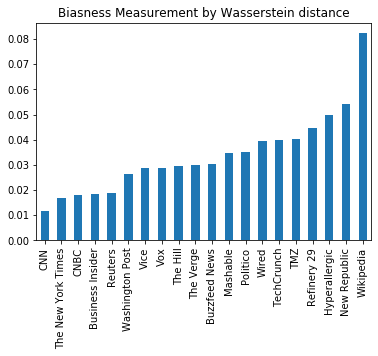

In [18]:
pd.Series(wscore_dict).sort_values().plot(kind='bar',title='Biasness Measurement by Wasserstein distance')

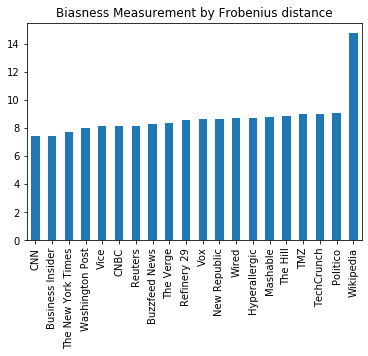

In [19]:
pd.Series(lscore_dict).sort_values().plot(kind='bar',title='Biasness Measurement by Frobenius distance')